In [1]:
import numpy as np
from scipy.optimize import minimize
from scipy.optimize import differential_evolution

%matplotlib ipympl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import Ellipse

from tqdm import tqdm

In [2]:
import os

parent_dir = os.path.dirname(os.getcwd())
print(parent_dir)  # Prints parent directory

os.chdir(parent_dir)
#print(os.getcwd())  # Prints current working directory

import mmars

c:\Users\malth\OneDrive - Aarhus Universitet\Dokumenter\AAU-Studie\10. semester\NEW GIT\MMARS


In [3]:
radar_model_1 = mmars.FmcwRadar(position=np.array([[0,0]]), signalNoiseRatio=[10, 10], N_chirps=1)
#radar_model_2 = mmars.FmcwRadar(position=np.array([[0,10]]), signalNoiseRatio=[10, 10], N_chirps=1)
#radar_model_3 = mmars.FmcwRadar(position=np.array([[0,20]]), signalNoiseRatio=[10, 10], N_chirps=1)

## Setting up the target

In [4]:
T_frame = 0.1

target_model_1 = mmars.Target(start_position=np.array([[0.001,5.001]]), start_velocity=1., T_total=15., T_frame=T_frame)

target_model_1.generate_trajectory(trajectory_type="linear")

target_ground_truth = target_model_1.get_trajectory()

print(radar_model_1.get_parameters)

mrblatcomp = mmars.MRBLaT_Functions(radar_model_1.get_parameters)

{'position': array([[0, 0]]), 'tx_antennas': array([[-0.02336045,  0.        ],
       [-0.01557363,  0.        ],
       [-0.00778682,  0.        ]]), 'rx_antennas': array([[-0.00292006,  0.        ],
       [-0.00097335,  0.        ],
       [ 0.00097335,  0.        ],
       [ 0.00292006,  0.        ]]), 'chirp_Rate': 30000000000000.0, 'T_between_chirps': 2.566e-05, 'f_carrier': 77000000000.0, 'N_samples': 256, 'f_sampling': 20000000.0, 'N_chirps': 1, 'transmitPower': 1, 'gain': 1, 'radarCrossSection': 1, 'signalNoiseRatio': [10, 10], 'standardDeviation': np.float64(2.763854534117991e-07), 'wavelength': 0.0038934085454545454, 'max_range': 99.93081933333333}


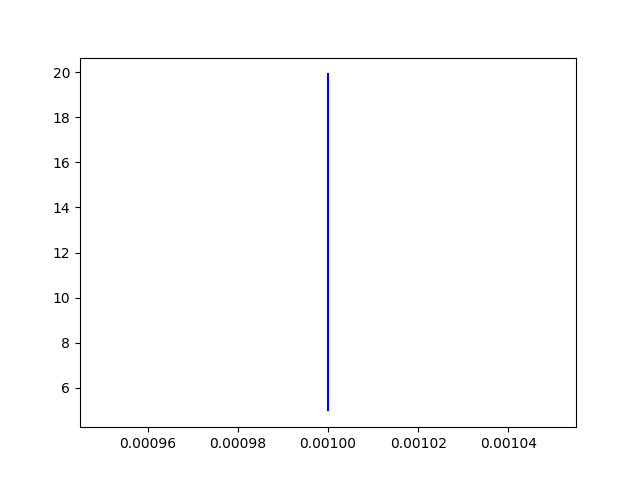

In [5]:
plt.figure()
plt.plot(target_ground_truth[0], target_ground_truth[1], label="Ground Truth", color="blue")

In [6]:
simulation_data_1 = mmars.Simulation(radar_model_1, target_model_1)
#simulation_data_2 = mmars.Simulation(radar_model_2, target_model_1)
#simulation_data_3 = mmars.Simulation(radar_model_3, target_model_1)

simulation_data_1.run()
#simulation_data_2.run()
#simulation_data_3.run()

Running simulation with <mmars.fmcwRadar.FmcwRadar object at 0x000001A9202DD250> and <mmars.target.Target object at 0x000001A920A26C00>


  0%|          | 0/150 [00:00<?, ?it/s]

100%|██████████| 150/150 [00:00<00:00, 916.07it/s]


In [7]:
sim_data_1 = simulation_data_1.get_data()
#sim_data_2 = simulation_data_2.get_data()
#sim_data_3 = simulation_data_3.get_data()

In [15]:
frame = 0

x0 = [target_ground_truth[0][frame], target_ground_truth[1][frame],0.1,0.1]
bound = ((-2, 2), (0, 20), (0.000001, 10), (0.000001, 10))


sim_data_all_virtual = sim_data_1[frame,:,:,0,:]
data_fourier = np.fft.fft(sim_data_1[frame], axis=-1).flatten()

D_KL_result = minimize(mrblatcomp.D_KL, x0, bounds = bound, args=(data_fourier, x0, (1,1,1,1), (1,1,1,1), False), method='nelder-mead', options={'xatol': 1e-10, 'disp': False})
D_KL_result.x

array([3.83082730e-04, 5.00150121e+00, 1.00000000e-06, 1.00000000e-06])

In [23]:
x0 = [target_ground_truth[0][0], target_ground_truth[1][0],0.1,0.1]
bound = ((-20, 20), (0, 20), (1e-10, 10), (1e-10, 10))

D_KL_results = np.zeros((len(sim_data_1), 4))

for n in tqdm(range(len(sim_data_1))):
    #print("Frame: ", n)
    data_fourier = np.fft.fft(sim_data_1[n], axis=-1).flatten()
    if n == 0:
        #print("First frame")
        D_KL_result = minimize(mrblatcomp.D_KL, x0, bounds = bound, args=(data_fourier, x0, (1,1,1,1), (1,1,1,1), False), method='nelder-mead', options={'xatol': 1e-10, 'disp': False})
    else:
        #print("Not first frame")
        D_KL_result = minimize(mrblatcomp.D_KL, D_KL_results[n-1], bounds = bound, args=(data_fourier, D_KL_results[n-1], (1,1,1,1), (1,1,1,1), False), method='nelder-mead', options={'xatol': 1e-10, 'disp': False})

    D_KL_results[n] = D_KL_result.x
    print(D_KL_result.x)
        

  1%|▏         | 2/150 [00:00<00:24,  5.92it/s]

[3.83082730e-04 5.00150121e+00 1.00000000e-10 1.00000000e-10]
[9.94428611e-04 5.10104335e+00 1.14633073e-10 1.16099654e-10]


  3%|▎         | 4/150 [00:00<00:26,  5.61it/s]

[1.10441039e-03 5.20067180e+00 1.00000000e-10 1.03256233e-10]
[1.34888157e-03 5.30076450e+00 1.00000000e-10 1.00000000e-10]


  4%|▍         | 6/150 [00:01<00:25,  5.65it/s]

[8.27879988e-04 5.40069264e+00 8.36137757e-10 4.11966867e-10]
[1.59332390e-03 5.50136570e+00 1.67901450e-09 5.52952575e-10]


  5%|▍         | 7/150 [00:01<00:24,  5.75it/s]

[1.93448998e-03 5.60050447e+00 1.61238083e-09 7.56830247e-10]


  6%|▌         | 9/150 [00:01<00:29,  4.80it/s]

[9.00113439e-04 5.70126409e+00 2.29575277e-05 1.08392479e-05]
[8.75178156e-04 5.80124169e+00 2.37950555e-05 1.07212236e-05]


  7%|▋         | 10/150 [00:01<00:27,  5.14it/s]

[1.25370908e-04 5.90094212e+00 2.72353572e-05 1.50423880e-05]


  7%|▋         | 11/150 [00:02<00:36,  3.79it/s]

[1.63872804e-03 6.00060911e+00 1.05214581e-04 1.41239494e-05]


  8%|▊         | 12/150 [00:02<00:41,  3.31it/s]

[-1.97570313e-04  6.10087528e+00  3.32825203e-05  2.03121197e-05]


  9%|▊         | 13/150 [00:03<00:42,  3.24it/s]

[1.47011383e-03 6.20059300e+00 1.78569655e-04 2.32000832e-05]


  9%|▉         | 14/150 [00:03<00:39,  3.45it/s]

[-3.42729675e-04  6.30057916e+00  3.69836467e-05  3.39331246e-05]


 11%|█         | 16/150 [00:03<00:36,  3.63it/s]

[2.50377317e-03 6.40068093e+00 3.61742370e-05 1.24642470e-05]
[7.08951540e-04 6.50118755e+00 5.08352335e-05 1.70186122e-05]


 11%|█▏        | 17/150 [00:04<00:41,  3.19it/s]

[-6.11048650e-05  6.60119307e+00  3.97872362e-05  1.32773924e-05]


 12%|█▏        | 18/150 [00:04<00:38,  3.39it/s]

[1.09995378e-03 6.70114868e+00 2.87723180e-04 1.37137230e-05]


 13%|█▎        | 19/150 [00:04<00:42,  3.09it/s]

[3.08933915e-04 6.80083766e+00 4.32080597e-05 1.39969415e-05]


 13%|█▎        | 20/150 [00:05<00:44,  2.91it/s]

[1.28911926e-03 6.90032974e+00 4.50517123e-05 1.43924270e-05]


 15%|█▍        | 22/150 [00:05<00:35,  3.56it/s]

[8.59750747e-04 7.00072719e+00 4.58060797e-05 1.46904324e-05]
[2.03141270e-03 7.10082671e+00 6.33992806e-05 1.53484236e-05]


 15%|█▌        | 23/150 [00:05<00:34,  3.65it/s]

[9.52175887e-05 7.20090805e+00 7.23441330e-05 2.23281418e-05]


 16%|█▌        | 24/150 [00:06<00:38,  3.31it/s]

[-2.47743943e-04  7.30045192e+00  1.72980593e-04  3.44133752e-05]


 17%|█▋        | 25/150 [00:06<00:45,  2.73it/s]

[1.65624044e-03 7.40064012e+00 5.73845753e-05 1.83214055e-05]


 17%|█▋        | 26/150 [00:07<00:41,  2.96it/s]

[-1.70065293e-03  7.50087728e+00  1.09554606e-04  2.21548110e-05]


 18%|█▊        | 27/150 [00:07<00:39,  3.14it/s]

[1.27063817e-03 7.60122530e+00 1.24398709e-04 5.32999883e-05]


 19%|█▉        | 29/150 [00:07<00:34,  3.47it/s]

[3.70225590e-03 7.70126468e+00 6.29289374e-05 1.80353640e-05]
[1.37242869e-05 7.80165804e+00 6.03707347e-05 2.86769331e-05]


 20%|██        | 30/150 [00:08<00:34,  3.45it/s]

[-3.84022056e-04  7.90059675e+00  6.43512683e-04  4.64014861e-05]


 21%|██▏       | 32/150 [00:08<00:30,  3.93it/s]

[2.93531284e-03 8.00060323e+00 7.05682940e-05 1.94527757e-05]
[9.58870848e-04 8.10112398e+00 1.12579920e-04 2.03117002e-05]


 22%|██▏       | 33/150 [00:08<00:26,  4.36it/s]

[7.50459122e-05 8.20110259e+00 8.89113581e-05 2.36462958e-05]


 23%|██▎       | 34/150 [00:09<00:27,  4.21it/s]

[1.54010964e-04 8.30051522e+00 1.27713609e-05 8.48903961e-06]


 23%|██▎       | 35/150 [00:09<00:26,  4.32it/s]

[7.11272447e-04 8.40223747e+00 1.52806004e-05 7.60104961e-06]


 24%|██▍       | 36/150 [00:09<00:25,  4.42it/s]

[-1.16709270e-03  8.50079900e+00  3.21888775e-05  2.18628965e-05]


 25%|██▍       | 37/150 [00:10<00:33,  3.39it/s]

[1.41014508e-03 8.60081937e+00 1.19729206e-04 2.00340806e-05]


 25%|██▌       | 38/150 [00:10<00:31,  3.52it/s]

[5.34657524e-03 8.70060894e+00 1.00000000e-10 1.94423601e-05]


 26%|██▌       | 39/150 [00:10<00:31,  3.54it/s]

[1.92790776e-03 8.80137695e+00 4.83214811e-10 3.57027311e-05]


 27%|██▋       | 40/150 [00:10<00:31,  3.53it/s]

[1.83406360e-03 8.90035144e+00 4.70540117e-09 1.45953223e-05]


 28%|██▊       | 42/150 [00:11<00:26,  4.15it/s]

[3.29757961e-03 9.00098631e+00 1.03210081e-08 7.92926394e-06]
[-1.10246036e-03  9.09994356e+00  4.74240888e-09  4.24099972e-06]


 29%|██▊       | 43/150 [00:11<00:28,  3.71it/s]

[6.68733934e-04 9.20024684e+00 1.14810761e-07 3.92386902e-05]


 29%|██▉       | 44/150 [00:11<00:28,  3.68it/s]

[-3.65728187e-03  9.30155517e+00  1.59735143e-04  2.72584085e-05]


 30%|███       | 45/150 [00:12<00:28,  3.62it/s]

[2.17536301e-03 9.40058041e+00 1.07574171e-04 4.78629737e-05]


 31%|███       | 46/150 [00:12<00:29,  3.58it/s]

[4.79652481e-04 9.50181062e+00 1.69549424e-04 2.77848905e-05]


 32%|███▏      | 48/150 [00:12<00:25,  3.97it/s]

[4.33021957e-03 9.60049438e+00 1.00000000e-10 2.78499523e-05]
[-8.35156046e-04  9.70088252e+00  3.17527177e-10  3.43185478e-05]


 33%|███▎      | 49/150 [00:13<00:30,  3.28it/s]

[-2.47513759e-04  9.80075677e+00  2.27281016e-09  2.15136715e-05]


 33%|███▎      | 50/150 [00:13<00:33,  3.02it/s]

[2.98696455e-03 9.90202791e+00 6.04922467e-08 3.03698347e-05]


 34%|███▍      | 51/150 [00:14<00:31,  3.17it/s]

[1.98994642e-03 1.00005438e+01 6.79436433e-07 5.41635119e-05]


 35%|███▍      | 52/150 [00:14<00:29,  3.30it/s]

[5.39220003e-03 1.00999842e+01 9.35568716e-07 2.70508383e-05]


 35%|███▌      | 53/150 [00:14<00:28,  3.38it/s]

[4.61140133e-03 1.01997991e+01 1.24926325e-06 4.12171585e-05]


 36%|███▌      | 54/150 [00:14<00:29,  3.28it/s]

[-6.03270195e-03  1.03025352e+01  1.51761960e-04  3.23912840e-05]


 37%|███▋      | 56/150 [00:15<00:25,  3.64it/s]

[9.52571873e-04 1.04012080e+01 1.00000000e-10 3.26752381e-05]
[1.21851657e-03 1.05021556e+01 1.60732418e-10 7.38980097e-06]


 38%|███▊      | 57/150 [00:15<00:27,  3.38it/s]

[-7.44005443e-03  1.06020131e+01  1.01552889e-09  3.55019020e-05]


 39%|███▉      | 59/150 [00:16<00:23,  3.85it/s]

[-4.53276088e-03  1.06995174e+01  1.37065481e-09  2.83092732e-05]
[1.22348902e-02 1.08003671e+01 1.00000000e-10 1.00000000e-10]


 40%|████      | 60/150 [00:16<00:30,  2.97it/s]

[1.82449848e-03 1.09000087e+01 8.96090304e-05 4.78682326e-05]


 41%|████      | 61/150 [00:17<00:29,  3.05it/s]

[-3.01797802e-03  1.10031772e+01  2.06946414e-04  3.74883053e-05]


 41%|████▏     | 62/150 [00:17<00:27,  3.15it/s]

[3.13705507e-03 1.10999515e+01 1.93729860e-04 8.61082103e-05]


 42%|████▏     | 63/150 [00:17<00:26,  3.30it/s]

[-5.37986405e-03  1.11996580e+01  7.05056578e-04  8.39064233e-05]


 43%|████▎     | 64/150 [00:17<00:28,  3.04it/s]

[-4.51406529e-03  1.12995244e+01  1.97482233e-04  3.84387875e-05]


 43%|████▎     | 65/150 [00:18<00:25,  3.31it/s]

[3.99292993e-03 1.14005152e+01 3.32451091e-04 7.21218961e-05]


 44%|████▍     | 66/150 [00:18<00:26,  3.17it/s]

[1.89246149e-03 1.15016598e+01 2.09512668e-04 4.01378904e-05]


 45%|████▍     | 67/150 [00:18<00:24,  3.34it/s]

[3.82998152e-03 1.16017251e+01 1.12860255e-04 2.17279963e-05]


 45%|████▌     | 68/150 [00:19<00:24,  3.38it/s]

[1.26031007e-02 1.17014565e+01 1.74936404e-04 4.58881497e-05]


 46%|████▌     | 69/150 [00:19<00:27,  2.96it/s]

[1.97532147e-04 1.17995905e+01 2.25958201e-04 4.22035398e-05]


 47%|████▋     | 70/150 [00:20<00:30,  2.60it/s]

[2.71437226e-03 1.19021293e+01 2.32367554e-04 4.30603114e-05]


 47%|████▋     | 71/150 [00:20<00:28,  2.82it/s]

[7.47090023e-04 1.20001051e+01 3.90771349e-04 1.16392779e-04]


 48%|████▊     | 72/150 [00:20<00:28,  2.72it/s]

[-5.84677051e-03  1.21012849e+01  2.47440217e-04  4.49607374e-05]


 49%|████▊     | 73/150 [00:21<00:28,  2.71it/s]

[9.03394774e-03 1.21987010e+01 2.50899720e-04 4.54536348e-05]


 49%|████▉     | 74/150 [00:21<00:26,  2.88it/s]

[4.54488384e-03 1.23007206e+01 3.26073981e-04 5.22653079e-05]


 50%|█████     | 75/150 [00:21<00:24,  3.09it/s]

[-3.07263447e-03  1.24010794e+01  3.22562222e-04  9.79998569e-05]


 51%|█████     | 76/150 [00:22<00:25,  2.90it/s]

[5.47043183e-03 1.25015304e+01 2.68910323e-04 4.74691821e-05]


 51%|█████▏    | 77/150 [00:22<00:23,  3.08it/s]

[-1.44732541e-02  1.26006188e+01  8.22451754e-04  1.11929308e-04]


 52%|█████▏    | 78/150 [00:22<00:24,  2.98it/s]

[2.36187214e-03 1.27012416e+01 2.83520607e-04 4.92227704e-05]


 53%|█████▎    | 79/150 [00:22<00:22,  3.12it/s]

[2.82489242e-03 1.28015057e+01 2.63583489e-04 4.77263058e-05]


 53%|█████▎    | 80/150 [00:23<00:22,  3.07it/s]

[8.39809233e-03 1.29011950e+01 2.65026004e-04 6.22841956e-05]


 54%|█████▍    | 81/150 [00:23<00:21,  3.18it/s]

[-4.73994774e-03  1.30021507e+01  4.30393548e-04  5.90603784e-05]


 55%|█████▍    | 82/150 [00:23<00:20,  3.24it/s]

[7.82102979e-03 1.31013181e+01 4.30814203e-04 1.30802378e-04]


 55%|█████▌    | 83/150 [00:24<00:22,  2.98it/s]

[-1.07005854e-03  1.31983316e+01  3.13437296e-04  5.23144685e-05]


 56%|█████▌    | 84/150 [00:24<00:21,  3.07it/s]

[1.72211738e-02 1.33033141e+01 3.38219069e-04 5.19507557e-05]


 57%|█████▋    | 85/150 [00:24<00:19,  3.29it/s]

[3.90593140e-03 1.34008836e+01 4.59121747e-04 8.03241614e-05]


 57%|█████▋    | 86/150 [00:25<00:21,  3.04it/s]

[-6.55358201e-04  1.35011336e+01  3.42780930e-04  5.59316518e-05]


 58%|█████▊    | 87/150 [00:25<00:21,  2.87it/s]

[3.17352862e-03 1.36027675e+01 3.47318519e-04 5.63175062e-05]


 59%|█████▊    | 88/150 [00:26<00:22,  2.71it/s]

[1.33844433e-02 1.37005871e+01 3.52481121e-04 5.69324197e-05]


 59%|█████▉    | 89/150 [00:26<00:20,  3.03it/s]

[2.30633048e-03 1.38001920e+01 5.76791648e-04 6.92500395e-05]


 60%|██████    | 90/150 [00:26<00:23,  2.56it/s]

[4.92344384e-03 1.38996793e+01 3.67772351e-04 5.83799825e-05]


 61%|██████    | 91/150 [00:27<00:22,  2.65it/s]

[1.54840432e-02 1.40026350e+01 3.79618128e-04 6.00653857e-05]


 61%|██████▏   | 92/150 [00:27<00:19,  2.91it/s]

[8.66713605e-03 1.41002826e+01 3.84477349e-04 6.02528161e-05]


 62%|██████▏   | 93/150 [00:27<00:20,  2.77it/s]

[-1.60160572e-03  1.42016024e+01  4.04044068e-04  6.26569158e-05]


 63%|██████▎   | 94/150 [00:28<00:19,  2.91it/s]

[2.04335859e-02 1.43056722e+01 1.11381063e-03 8.25346465e-05]


 63%|██████▎   | 95/150 [00:28<00:19,  2.80it/s]

[5.89562015e-04 1.44021121e+01 4.03252027e-04 6.17044806e-05]


 64%|██████▍   | 96/150 [00:28<00:19,  2.71it/s]

[4.06765527e-03 1.45011214e+01 4.18041252e-04 6.35418122e-05]


 65%|██████▍   | 97/150 [00:29<00:18,  2.89it/s]

[-5.64137440e-04  1.45995193e+01  5.24716729e-04  9.22664017e-05]


 65%|██████▌   | 98/150 [00:29<00:19,  2.65it/s]

[2.78748687e-03 1.47020308e+01 4.39210390e-04 6.58694180e-05]


 66%|██████▌   | 99/150 [00:30<00:20,  2.43it/s]

[2.17837792e-02 1.48017167e+01 4.44873503e-04 6.67295499e-05]


 67%|██████▋   | 100/150 [00:30<00:18,  2.70it/s]

[1.72543698e-02 1.49008785e+01 4.98307503e-04 7.59832200e-05]


 67%|██████▋   | 101/150 [00:30<00:18,  2.65it/s]

[-3.11203208e-03  1.49981686e+01  4.67161420e-04  6.85545902e-05]


 68%|██████▊   | 102/150 [00:31<00:18,  2.60it/s]

[1.87023014e-02 1.51013840e+01 5.24163259e-04 8.95437591e-05]


 69%|██████▉   | 104/150 [00:31<00:14,  3.11it/s]

[-1.10190155e-02  1.52022922e+01  4.77722733e-04  6.89758845e-05]
[-4.31803726e-04  1.53011872e+01  5.34743794e-04  7.17048538e-05]


 70%|███████   | 105/150 [00:32<00:13,  3.26it/s]

[-6.82206782e-05  1.53986483e+01  7.46512346e-04  1.05277935e-04]


 71%|███████   | 106/150 [00:32<00:12,  3.42it/s]

[-9.25254429e-05  1.54995067e+01  5.87366070e-04  8.27603516e-05]


 71%|███████▏  | 107/150 [00:32<00:12,  3.50it/s]

[-3.28954191e-05  1.56014453e+01  7.00596852e-04  1.08438643e-04]


 72%|███████▏  | 108/150 [00:32<00:11,  3.65it/s]

[-3.29350958e-05  1.56977771e+01  5.61639782e-04  7.16725113e-05]


 73%|███████▎  | 109/150 [00:33<00:12,  3.38it/s]

[-3.45220715e-05  1.58007077e+01  5.62642085e-04  7.81048580e-05]


 73%|███████▎  | 110/150 [00:33<00:12,  3.24it/s]

[-3.75839608e-05  1.59022167e+01  5.30102472e-04  7.29433455e-05]


 74%|███████▍  | 111/150 [00:33<00:12,  3.18it/s]

[1.30286981e-03 1.60028931e+01 3.20197122e-03 1.43386249e-05]


 75%|███████▍  | 112/150 [00:34<00:11,  3.32it/s]

[2.22451304e-03 1.61007090e+01 5.98659242e-04 8.34612613e-05]


 75%|███████▌  | 113/150 [00:34<00:11,  3.14it/s]

[-7.49142306e-03  1.61953076e+01  5.87976605e-04  7.97583772e-05]


 77%|███████▋  | 115/150 [00:35<00:10,  3.42it/s]

[4.69109278e-03 1.62968978e+01 5.94213356e-04 8.04563373e-05]
[-3.10261279e-02  1.63998288e+01  7.94447811e-04  1.21405006e-04]


 77%|███████▋  | 116/150 [00:35<00:09,  3.56it/s]

[1.28240430e-03 1.65014143e+01 6.19041015e-04 8.47635069e-05]


 78%|███████▊  | 117/150 [00:35<00:09,  3.31it/s]

[3.20882190e-02 1.66014712e+01 6.24983733e-04 8.38316439e-05]


 79%|███████▊  | 118/150 [00:35<00:09,  3.52it/s]

[8.18441673e-04 1.67028832e+01 6.27310508e-04 8.37520733e-05]


 79%|███████▉  | 119/150 [00:36<00:08,  3.62it/s]

[5.64319481e-04 1.67967235e+01 6.71511445e-04 1.20490636e-04]


 80%|████████  | 120/150 [00:36<00:09,  3.11it/s]

[-1.82552453e-02  1.69055172e+01  8.37115813e-03  2.81492939e-04]


 81%|████████▏ | 122/150 [00:37<00:08,  3.44it/s]

[-2.45098342e-02  1.70021343e+01  6.69194614e-04  8.59820579e-05]
[-1.20264337e-02  1.71001063e+01  8.00289234e-04  8.25295578e-05]


 82%|████████▏ | 123/150 [00:37<00:08,  3.35it/s]

[2.13172322e-02 1.71997374e+01 6.96756386e-04 8.98929617e-05]


 83%|████████▎ | 124/150 [00:37<00:08,  3.07it/s]

[-3.32374946e-02  1.73010373e+01  7.30509231e-04  9.20004469e-05]


 83%|████████▎ | 125/150 [00:38<00:07,  3.36it/s]

[-3.07148317e-02  1.74036183e+01  6.99515063e-04  9.63000464e-05]


 84%|████████▍ | 126/150 [00:38<00:07,  3.15it/s]

[2.99364022e-03 1.75048567e+01 7.34050804e-04 9.24847635e-05]


 85%|████████▍ | 127/150 [00:38<00:07,  2.94it/s]

[1.33588270e-02 1.75965447e+01 7.44758356e-04 9.36584457e-05]


 85%|████████▌ | 128/150 [00:39<00:06,  3.23it/s]

[-1.06792721e-02  1.76977831e+01  7.81121990e-04  8.05926241e-05]


 86%|████████▌ | 129/150 [00:39<00:06,  3.29it/s]

[-2.04515938e-02  1.78023510e+01  7.94109863e-04  9.77119698e-05]


 87%|████████▋ | 130/150 [00:39<00:05,  3.53it/s]

[-2.36271833e-02  1.79050449e+01  8.20617789e-04  9.84101170e-05]


 87%|████████▋ | 131/150 [00:39<00:05,  3.79it/s]

[-2.36795488e-02  1.80040241e+01  8.15949382e-04  9.76995044e-05]


 88%|████████▊ | 132/150 [00:40<00:05,  3.33it/s]

[2.98247712e-02 1.81030418e+01 8.01818878e-04 1.00000000e-10]


 89%|████████▉ | 134/150 [00:40<00:04,  3.37it/s]

[1.91369230e-02 1.82034793e+01 8.66321671e-04 8.59781005e-05]
[-1.20449120e-03  1.82955323e+01  9.32689445e-04  1.51431094e-04]


 91%|█████████ | 136/150 [00:41<00:03,  3.63it/s]

[2.42795943e-02 1.83994836e+01 8.55703127e-04 1.03333132e-04]
[2.49489530e-02 1.84960417e+01 8.41216198e-04 1.03489584e-04]


 91%|█████████▏| 137/150 [00:41<00:03,  3.71it/s]

[7.86282661e-03 1.86045864e+01 8.38700644e-04 1.01831832e-04]


 92%|█████████▏| 138/150 [00:41<00:03,  3.84it/s]

[3.70232926e-03 1.87049960e+01 1.25360104e-03 1.09496964e-04]


 93%|█████████▎| 139/150 [00:42<00:03,  3.33it/s]

[5.11023339e-02 1.88005044e+01 3.85398606e-04 7.21459720e-04]


 93%|█████████▎| 140/150 [00:42<00:02,  3.35it/s]

[-8.34230578e-02  1.88994220e+01  1.98177332e-03  1.07327062e-04]


 95%|█████████▍| 142/150 [00:43<00:02,  3.91it/s]

[-5.47640454e-03  1.89954191e+01  1.10548042e-03  1.89185759e-04]
[-6.68034919e-03  1.91015280e+01  1.22363446e-03  1.17109486e-04]


 95%|█████████▌| 143/150 [00:43<00:01,  3.93it/s]

[2.13746264e-02 1.92003234e+01 9.61491271e-04 1.08524496e-04]


 96%|█████████▌| 144/150 [00:43<00:01,  3.68it/s]

[8.52788946e-03 1.92986580e+01 1.27498556e-03 9.85097902e-05]


 97%|█████████▋| 145/150 [00:43<00:01,  3.30it/s]

[-2.39785884e-03  1.94088807e+01  1.26208826e-03  1.85894528e-04]


 97%|█████████▋| 146/150 [00:44<00:01,  2.93it/s]

[2.81225645e-02 1.94995133e+01 9.90702694e-04 1.12960739e-04]


 99%|█████████▊| 148/150 [00:44<00:00,  3.43it/s]

[-3.61811220e-02  1.96023334e+01  1.04839956e-03  1.16412126e-04]
[2.06045216e-02 1.96938208e+01 1.42278906e-03 7.87992745e-05]


 99%|█████████▉| 149/150 [00:45<00:00,  3.15it/s]

[-4.50973348e-02  1.98000267e+01  1.08469392e-03  1.18892771e-04]


100%|██████████| 150/150 [00:45<00:00,  3.28it/s]

[-1.10604316e-02  1.99051684e+01  1.12426096e-03  1.23965959e-04]


# MRBLaT

In [10]:
first_try = mmars.Tracking([sim_data_1], [radar_model_1.get_parameters], np.array([[target_ground_truth[0][0]], [target_ground_truth[1][0]], [target_ground_truth[2][0]], [target_ground_truth[3][0]]]))

In [11]:
BLaT_phi_bar_sim, BLaT_phi_bar_bar_sim, alpha_hat, alpha_times_S, DKL_phi_bar, DKL_phi_bar_bar = first_try.run_mrblat(T_frame, N_frames=20, fifo_length=None,  bound = ((-2, 2), (0, 10), (0.00001, 10), (0.00001, 10)))

  5%|▌         | 1/20 [00:00<00:04,  3.87it/s]

neldermead: [-1.85732861e-01  1.00000000e+01  6.25458194e-02  1.00000000e-05]


 10%|█         | 2/20 [00:00<00:04,  3.65it/s]

neldermead: [ 2.         10.          1.41131879  0.55814868]


c:\Users\malth\OneDrive - Aarhus Universitet\Dokumenter\AAU-Studie\10. semester\NEW GIT\MMARS\mmars\mrblatFunctions.py:63: RuntimeWarning: divide by zero encountered in scalar divide
  theta = np.atan(x/y)
c:\Users\malth\OneDrive - Aarhus Universitet\Dokumenter\AAU-Studie\10. semester\NEW GIT\MMARS\mmars\mrblatFunctions.py:81: RuntimeWarning: divide by zero encountered in scalar divide
  dsinthetadx = y/np.sqrt(x**2/y**2+1)/r**2
c:\Users\malth\OneDrive - Aarhus Universitet\Dokumenter\AAU-Studie\10. semester\NEW GIT\MMARS\mmars\mrblatFunctions.py:82: RuntimeWarning: divide by zero encountered in scalar divide
  dsinthetady = -x/np.sqrt(x**2/y**2+1)/r**2
 15%|█▌        | 3/20 [00:00<00:05,  3.31it/s]

neldermead: [-1.89108901 10.         10.          6.76814638]


 25%|██▌       | 5/20 [00:01<00:03,  4.16it/s]

neldermead: [-2.         10.         10.          4.08680728]
neldermead: [-2.         10.         10.          3.55962256]


 35%|███▌      | 7/20 [00:01<00:02,  5.69it/s]

neldermead: [-2. 10. 10. 10.]
neldermead: [-2.         10.         10.          4.15171082]


 45%|████▌     | 9/20 [00:01<00:01,  5.82it/s]

neldermead: [-2.         10.         10.          2.04199063]
neldermead: [-2.         10.         10.          6.22159934]


 55%|█████▌    | 11/20 [00:02<00:01,  7.47it/s]

neldermead: [-2. 10. 10. 10.]
neldermead: [-2.         10.         10.          6.36966349]


 65%|██████▌   | 13/20 [00:02<00:00,  7.12it/s]

neldermead: [-2.       10.       10.        5.873519]
neldermead: [-2.         10.         10.          4.32900235]
neldermead: [-2. 10. 10. 10.]


 80%|████████  | 16/20 [00:02<00:00,  8.05it/s]

neldermead: [-2.         10.         10.          4.66558598]
neldermead: [-2.         10.         10.          4.66720811]


 90%|█████████ | 18/20 [00:02<00:00,  6.85it/s]

neldermead: [-2.       10.       10.        4.368572]
neldermead: [-2.         10.         10.          4.96095364]


 95%|█████████▌| 19/20 [00:03<00:00,  5.97it/s]

neldermead: [-2.         10.         10.          4.51630345]


100%|██████████| 20/20 [00:03<00:00,  5.84it/s]

neldermead: [-2.         10.         10.          6.39096512]


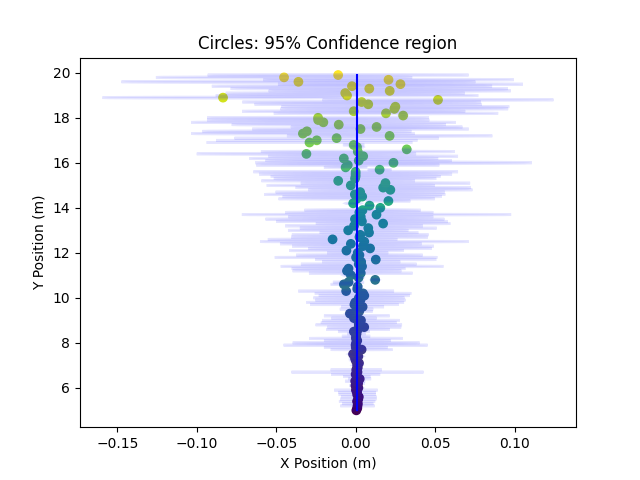

In [17]:
plt.figure()
plt.scatter(D_KL_results[:, 0], D_KL_results[:, 1], label="MRBLAT", c=np.linspace(0, 1, len(D_KL_results[:, 0])), cmap='viridis', marker='o')
plt.plot(target_ground_truth[0][:500], target_ground_truth[1][:500], label="Ground Truth", color="blue")
plt.xlabel("X Position (m)")
plt.ylabel("Y Position (m)")
plt.title('Circles: 95% Confidence region')
#plt.ylim(-1, 30)

for N_frame in range(len(D_KL_results)):
    mean_MR = np.array([D_KL_results[N_frame,0], D_KL_results[N_frame,1]])
    cov_MR = np.array([[D_KL_results[N_frame, 2], 0],
                   [0, D_KL_results[N_frame, 3]]])
    x_MR, y_MR = np.random.multivariate_normal(mean_MR, cov_MR, 10000).T
    # Calculate eigenvalues and eigenvectors of the covariance matrix
    eigenvalues_MR, eigenvectors_MR = np.linalg.eigh(cov_MR)
    order_MR = eigenvalues_MR.argsort()[::-1]
    eigenvalues_MR, eigenvectors_MR = eigenvalues_MR[order_MR], eigenvectors_MR[:, order_MR]
    angle_MR = np.degrees(np.arctan2(*eigenvectors_MR[:, 0][::-1]))
    width_MR, height_MR = 2 * np.sqrt(eigenvalues_MR * 5.991)  # 5.991 is the chi-square value for 95% confidence
    # Create and add the ellipse to the plot
    ellipse_MR = Ellipse(xy=mean_MR, width=width_MR, height=height_MR, angle=angle_MR, edgecolor='blue', fc='blue', lw=2, alpha=0.1)
    plt.gca().add_patch(ellipse_MR)

Text(0, 0.5, 'Standard Deviation (m)')

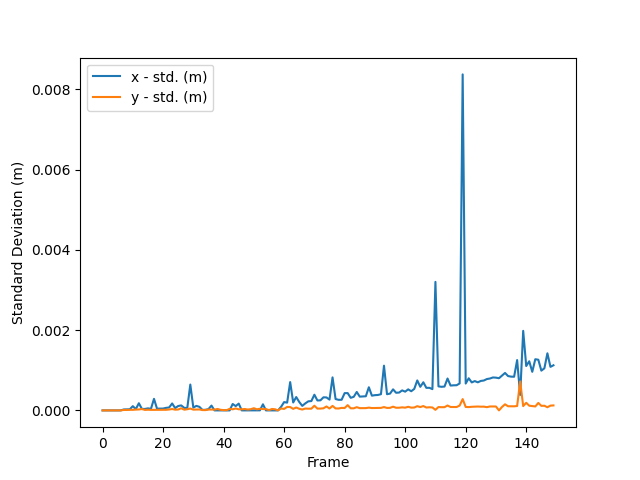

In [24]:
plt.figure()
plt.plot(D_KL_results[:, 2], label="x - std. (m)")
plt.plot(D_KL_results[:, 3], label="y - std. (m)")
plt.xlabel("Frame")
plt.legend()
plt.ylabel("Standard Deviation (m)")

In [8]:
gridsize = 250

# Define the range for phi[0] and phi[1]
x_values = np.linspace(-50, 50, gridsize)  # 0 to 50 (inclusive)
y_values = np.linspace(3, 50.0001, gridsize)

# Create a grid of all combinations of phi[0] and phi[1]

X, Y = np.meshgrid(x_values, y_values)

# Flatten the grid and stack with phi[2] = 0, phi[3] = 0
phis = [np.array([[x], [y], [2],  [2]]) for x, y in zip(X.ravel(), Y.ravel())]

# Convert to NumPy array (shape: (2500, 4, 1))
phis = np.array(phis)

print(f"Shape of phis: {phis.shape}")  # Expected: (2500, 4, 1)
#print(phis[:-2])  # Print first few vectors

Shape of phis: (62500, 4, 1)


In [9]:
frame = 1
sim_data_all_virtual = sim_data_1[frame,:,:,0,:]
data_fourier = np.fft.fft(sim_data_1[frame], axis=-1).flatten()
S_signals = []
for n in tqdm(range(len(phis))):
    S_signals.append(mrblatcomp.D_KL(phis[n][:4].flatten(), data_fourier, [target_model_1.get_trajectory()[0][frame-1], target_model_1.get_trajectory()[0][frame-1], 2, 2], outputmode=[1,1,1,1], print_output=False))

100%|██████████| 62500/62500 [00:42<00:00, 1454.21it/s]


Minimum value at index: (np.int64(11), np.int64(125))
x: 0.20080321285140457, y: 5.076309638554217


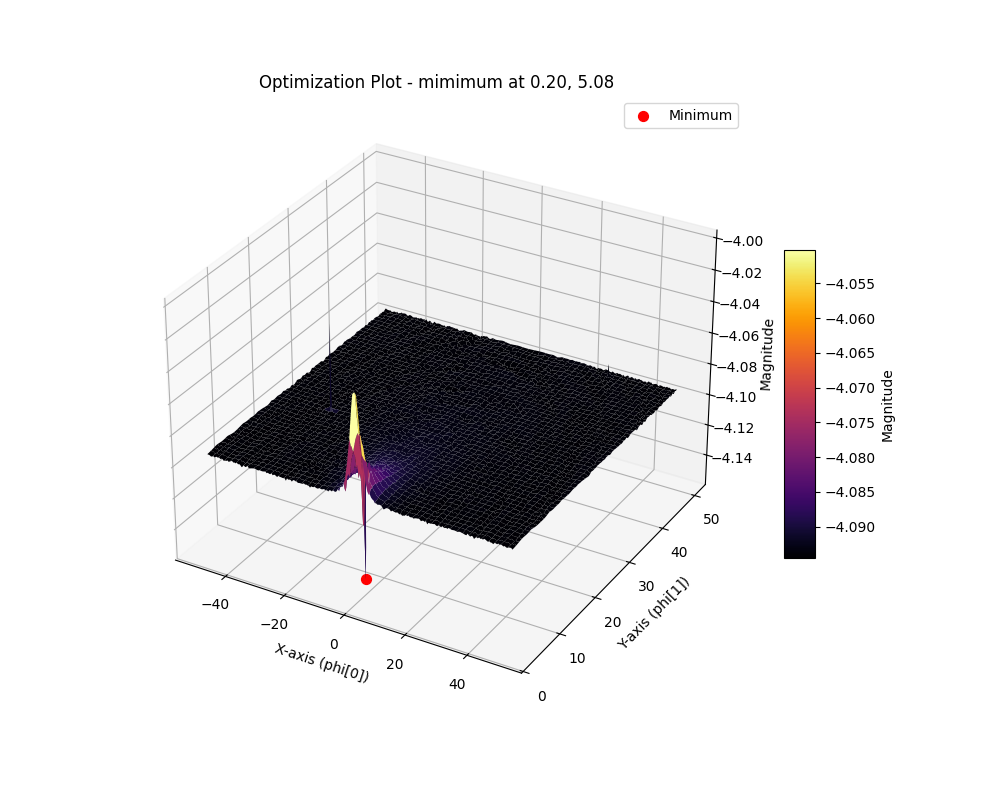

In [10]:
# Reshape to 2D (51x51) for heatmap plotting
heatmap = np.array(S_signals).reshape(gridsize, gridsize)
heatmap = np.real(heatmap)
min_index = np.argmin(heatmap)
min_index_2d = np.unravel_index(min_index, heatmap.shape)
x_min = x_values[min_index_2d[1]]
y_min = y_values[min_index_2d[0]]

print(f"Minimum value at index: {min_index_2d}")
print(f"x: {x_min}, y: {y_min}")
np.min(np.abs(heatmap))

# Plot the heatmap
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Create a meshgrid for x_values and y_values
X, Y = np.meshgrid(x_values, y_values)

# Plot the surface
surf = ax.plot_surface(X, Y, heatmap, cmap='inferno', edgecolor='none')

# Add a scatter point for the minimum value
ax.scatter(x_min, y_min, np.min(heatmap), color='red', label='Minimum', s=50)

# Add color bar
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10, label="Magnitude")

# Set labels and title
ax.set_xlabel("X-axis (phi[0])")
ax.set_ylabel("Y-axis (phi[1])")
ax.set_zlabel("Magnitude")
ax.set_title(f"Optimization Plot - mimimum at {x_min:.2f}, {y_min:.2f}")

plt.legend()
plt.show()

In [23]:
gridsize = 250

# Define the range for phi[0] and phi[1]
x_values = 10**(np.linspace(-100, 20, gridsize)/20) 
y_values = 10**(np.linspace(-100, 20, gridsize)/20)

#x_values = np.linspace(1e-15, 2, gridsize)
#y_values = np.linspace(1e-15, 2, gridsize)
# Create a grid of all combinations of phi[0] and phi[1]

X, Y = np.meshgrid(x_values, y_values)

# Flatten the grid and stack with phi[2] = 0, phi[3] = 0
phis = [np.array([[x_min], [y_min], [x],  [y]]) for x, y in zip(X.ravel(), Y.ravel())]

# Convert to NumPy array (shape: (2500, 4, 1))
phis = np.array(phis)

print(f"Shape of phis: {phis.shape}")  # Expected: (2500, 4, 1)
#print(phis[:-2])  # Print first few vectors

Shape of phis: (62500, 4, 1)


In [24]:
frame = 1
sim_data_all_virtual = sim_data_1[frame,:,:,0,:]
data_fourier = np.fft.fft(sim_data_1[frame], axis=-1).flatten()
S_signals = []
for n in tqdm(range(len(phis))):
    S_signals.append(mrblatcomp.D_KL(phis[n][:4].flatten(), data_fourier, [x_min, y_min, 2, 2], print_output=False))

100%|██████████| 62500/62500 [00:31<00:00, 1984.08it/s]


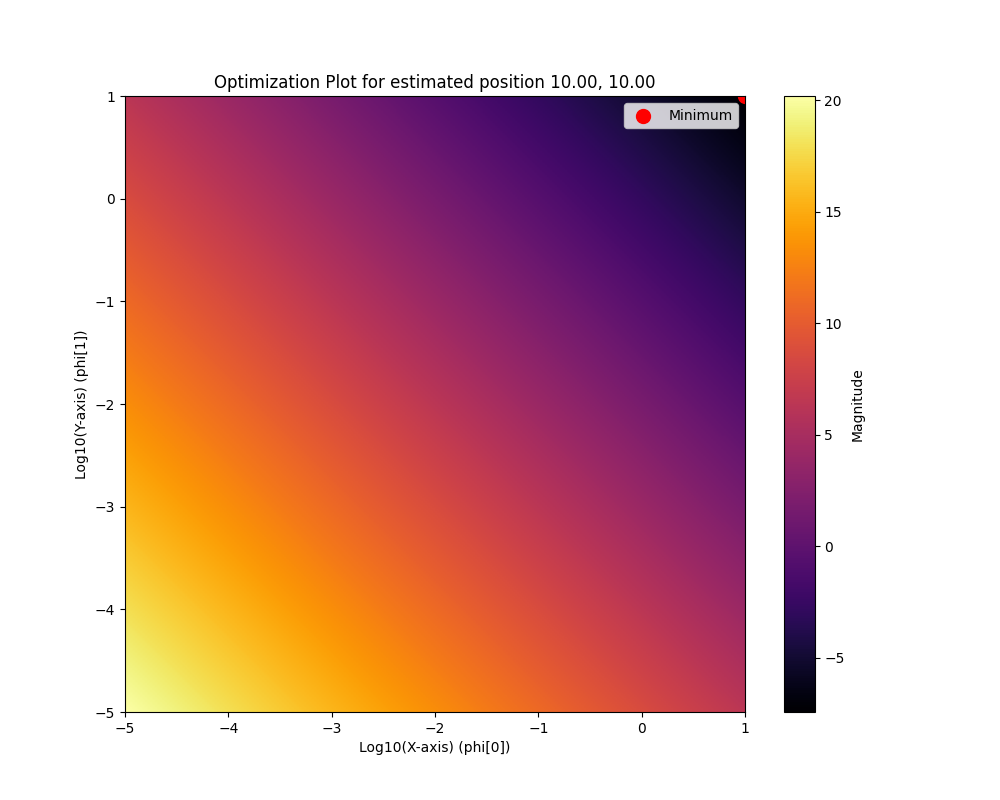

In [25]:
heatmap = np.array(S_signals).reshape(gridsize, gridsize)

# Plot the heatmap
plt.figure(figsize=(10, 8))

# Create a meshgrid for x_values and y_values
X, Y = np.meshgrid(x_values, y_values)

# Plot the heatmap
plt.imshow(heatmap.real, origin='lower', extent=[np.log10(x_values[0]), np.log10(x_values[-1]), np.log10(y_values[0]), np.log10(y_values[-1])], cmap='inferno', aspect='auto')

# Add color bar
plt.colorbar(label="Magnitude")

min_index = np.argmin(heatmap)
min_index_2d = np.unravel_index(min_index, heatmap.shape)
x_min = x_values[min_index_2d[1]]
y_min = y_values[min_index_2d[0]]

# Add a scatter point for the minimum value
plt.scatter(np.log10(x_min), np.log10(y_min), color='red', label='Minimum', s=100)



# Set labels and title
plt.xlabel("Log10(X-axis) (phi[0])")
plt.ylabel("Log10(Y-axis) (phi[1])")
plt.title(f"Optimization Plot for estimated position {x_min:.2f}, {y_min:.2f}")

plt.legend()
plt.show()
